# **Machine Translation - CSCE 636 Project**

## **Introduction**

The goal of this project is to implement a machine translation model. In the first step, a dataset of German to English terms will be used to train a translation model. The dataset can be accessed here:

[German-English deu-eng.zip](http://www.manythings.org/anki/deu-eng.zip)

## **Load the Dataset**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Unzip the data file
import zipfile
zip_ref = zipfile.ZipFile('deu-eng.zip', 'r')
zip_ref.extractall('data-deu-eng')
zip_ref.close()

The file called deu.txt that contains 152,820 pairs of English to German phases, one pair per line with a tab separating the language.

In [3]:
# First 5 lines of the deu.txt file
import re
with open("data-deu-eng/deu.txt") as datafile:
    head = [next(datafile) for x in range(5)]

for pair in head:
  print(re.sub('\s+',' ',pair))

Hi. Hallo! 
Hi. Grüß Gott! 
Run! Lauf! 
Wow! Potzdonner! 
Wow! Donnerwetter! 


## **Prepare the Text Data**

Reviewing the raw data, there are some observations:
* Punctuation;
* Uppercase and lowercase; 
* Special characters in German; 
* Same phrases in English with different translations in German.

Therefore, it is necessary to clean the data. So the data preparation is divided into two subsections:
**clean text and split text**.

In [4]:
# load doc into memory
import string
from pickle import dump
from unicodedata import normalize
from numpy import array

def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8') # preserving the Unicode German characters
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

**1. Clean Text**

In [5]:
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines] # seperate the English and German phrases
	return pairs

In [6]:
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
  
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			line = normalize('NFD', line).encode('ascii', 'ignore') # normalize unicode characters
			line = line.decode('UTF-8')
			line = line.split()
			line = [word.translate(table) for word in line]         # remove punctuation from each token
			line = [re_print.sub('', w) for w in line]              # remove non-printable chars form each token
			line = [word for word in line if word.isalpha()]        # remove tokens with numbers in them
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

In [7]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = 'data-deu-eng/deu.txt'
doc = load_doc(filename)
pairs = to_pairs(doc)
clean_pairs = clean_pairs(pairs)

# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')

# spot check
for i in range(10):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[Hi] => [Hallo]
[Hi] => [Gru Gott]
[Run] => [Lauf]
[Wow] => [Potzdonner]
[Wow] => [Donnerwetter]
[Fire] => [Feuer]
[Help] => [Hilfe]
[Help] => [Zu Hulf]
[Stop] => [Stopp]
[Wait] => [Warte]


**2. Split Text**

The cleaned data now has over 150,000 phrase pairs. Here, the first 100,000 examples will be used - the first 80,000 examples for training and the remaining 20,000 for validation and testing, 10,000 for each. 

In [13]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 90000
dataset = raw_dataset[:n_sentences, :]

# random shuffle
shuffle(dataset)
shuffle(dataset)

# split into train/test
train, vali = dataset[:75000], dataset[75000:82500]
test = dataset[82500:]
# save training/testing data
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(vali, 'english-german-vali.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-vali.pkl
Saved: english-german-test.pkl


## Train the Model

In [9]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from attention_decoder import AttentionDecoder

Using TensorFlow backend.


In [10]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
  
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
  
	return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

In [11]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
vali = load_clean_sentences('english-german-vali.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare validation data
valiX = encode_sequences(ger_tokenizer, ger_length, vali[:, 1])
valiY = encode_sequences(eng_tokenizer, eng_length, vali[:, 0])
valiY = encode_output(valiY, eng_vocab_size)

# prepare test data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

English Vocabulary Size: 9118
English Max Length: 9
German Vocabulary Size: 16398
German Max Length: 17


In [12]:
# define baseline NMT model
def define_baseline_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(LSTM(n_units))
#   model.add(AttentionL(src_timesteps))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(n_units, return_sequences=True))
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  return model

# define model
model = define_baseline_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=30, batch_size=256, validation_data=(valiX, valiY), callbacks=[checkpoint], verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 256)           4197888   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 9, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 9118)           2343326   
Total params: 7,591,838
Trainable params: 7,591,838
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train o

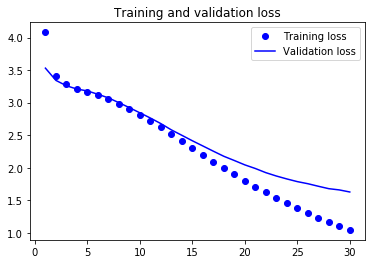

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# define bidirectional model
def define_bidirectional_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(Bidirectional(LSTM(n_units, dropout=0.5)))
  model.add(RepeatVector(tar_timesteps))
  model.add(Bidirectional(LSTM(n_units, return_sequences=True, dropout=0.5)))
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  return model

In [17]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

bi_trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
bi_trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
bi_trainY = encode_output(bi_trainY, eng_vocab_size)

# prepare validation data
bi_valiX = encode_sequences(ger_tokenizer, ger_length, vali[:, 1])
bi_valiY = encode_sequences(eng_tokenizer, eng_length, vali[:, 0])
bi_valiY = encode_output(bi_valiY, eng_vocab_size)

bi_testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
bi_testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
bi_testY = encode_output(bi_testY, eng_vocab_size)

bi_model = define_bidirectional_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
bi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize defined model
print(bi_model.summary())
plot_model(bi_model, to_file='bi_model.png', show_shapes=True)

# fit model
filename = 'bi_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
bi_history = bi_model.fit(bi_trainX, bi_trainY, epochs=30, batch_size=256, validation_data=(bi_valiX, bi_valiY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 9118
English Max Length: 9
German Vocabulary Size: 16398
German Max Length: 17
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 17, 256)           4197888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1050624   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 9, 512)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 9, 512)            1574912   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 9118)           4677534   
Total params: 11,500,958
Trainable params: 11,500,958
N

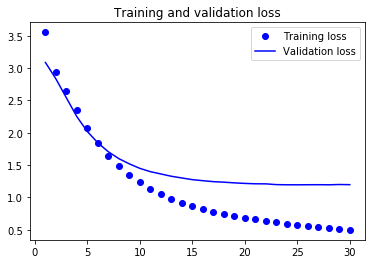

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = bi_history.history['loss']
val_loss = bi_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
from AttentionMechanism import AttentionL
# define attention model
def define_attention_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(Bidirectional(LSTM(n_units, return_sequences=True, dropout=0.5)))
  model.add(AttentionL(src_timesteps))
  model.add(RepeatVector(tar_timesteps))
  model.add(Bidirectional(LSTM(n_units, return_sequences=True, dropout=0.5)))
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  return model

In [20]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

attention_trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
attention_trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
attention_trainY = encode_output(attention_trainY, eng_vocab_size)

attention_valiX = encode_sequences(ger_tokenizer, ger_length, vali[:, 1])
attention_valiY = encode_sequences(eng_tokenizer, eng_length, vali[:, 0])
attention_valiY = encode_output(attention_valiY, eng_vocab_size)

attention_testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
attention_testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
attention_testY = encode_output(attention_testY, eng_vocab_size)

attention_model = define_attention_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize defined model
print(attention_model.summary())
plot_model(attention_model, to_file='attention_model.png', show_shapes=True)

# fit model
filename = 'attention_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
attention_history = attention_model.fit(attention_trainX, attention_trainY, epochs=30, batch_size=256, validation_data=(attention_valiX, attention_valiY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 9118
English Max Length: 9
German Vocabulary Size: 16398
German Max Length: 17
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 17, 256)           4197888   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 17, 512)           1050624   
_________________________________________________________________
attention_l_1 (AttentionL)   (None, 512)               529       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 9, 512)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 9, 512)            1574912   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 9118)           4677534   
Total params: 11,501,487
Trainable par

KeyboardInterrupt: 

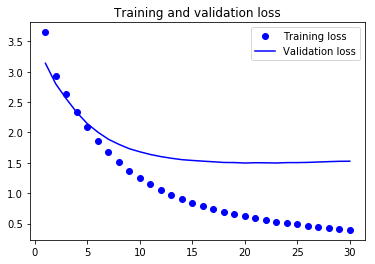

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = attention_history.history['loss']
val_loss = attention_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate the Model

In [21]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [22]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [23]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [24]:
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
  smoothie = SmoothingFunction().method4
  actual, predicted = list(), list()
  correct_num = 0
  total = 0
  for i, source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    raw_target, raw_src = raw_dataset[i]
    total += 1
    if translation == raw_target.lower():
      correct_num += 1
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
    actual.append(raw_target.split())
    predicted.append(translation.split())
	# calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothie))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smoothie))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))
  # calculate accuracy
  print("absolute accuracy=[%f], " %float(correct_num / total))

In [40]:
# load model
print()
print("Loading baseline model:")

model = load_model('model.h5')

# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)


Loading baseline model:
train
src=[Du hast echt n Knall], target=[Youre such a weirdo], predicted=[youre have a weirdo]
src=[Da sind wir], target=[Here we are], predicted=[were we are]
src=[Er ist in meiner Klasse], target=[Hes in my class], predicted=[hes in my my]
src=[Er hatte die richtige Idee], target=[He had the right idea], predicted=[he was the plan]
src=[Tom kam gut zu Hause an], target=[Tom arrived home safely], predicted=[tom arrived home home]
src=[Ich habe mit dem Rauchen aufgehort], target=[I quit smoking], predicted=[i quit smoking smoking]
src=[Macht euch keine Gedanken Ich sage nichts], target=[Dont worry I wont tell], predicted=[dont worry i i say]
src=[Tom zerriss den Scheck], target=[Tom ripped up the check], predicted=[tom ripped up the]
src=[Er ist an dieser Krankheit gestorben], target=[He died of that disease], predicted=[he died his his disease]
src=[Er hat sich den Arm ausgerenkt], target=[He dislocated his arm], predicted=[he dislocated his arm]
BLEU-1: 0.05

In [25]:
# load bidirectional model
print()
print("Loading bidirectional model:")
bi_model = load_model('bi_model.h5')
print('train')
evaluate_model(bi_model, eng_tokenizer, bi_trainX, train)
# test on some test sequences
print('test')
evaluate_model(bi_model, eng_tokenizer, bi_testX, test)


Loading bidirectional model:
train
src=[Tom hat geschummelt], target=[Tom was cheating], predicted=[tom cheated]
src=[Ich flehe dich an mir zu helfen], target=[I beg you to help me], predicted=[i beg you to help me]
src=[Tom ist wutend], target=[Tom is furious], predicted=[tom is furious]
src=[Wir haben alles gesehen], target=[We saw everything], predicted=[we saw everything]
src=[Ich sagte ich erinnere mich nicht], target=[I said I didnt remember], predicted=[i said i didnt remember]
src=[Sie sollten sich einen Tag freinehmen], target=[You should take a day off], predicted=[you should take a day off]
src=[Es gibt keine andere Erklarung], target=[Theres no other explanation], predicted=[theres no no other]
src=[Das ist die Kamera meiner Schwester], target=[Thats my sisters camera], predicted=[this my sisters sisters]
src=[Nehmen Sie die nachste Strae rechts], target=[Take the next right], predicted=[take the next right]
src=[Das war unverzeihlich], target=[That was unforgivable], pred

In [56]:
# load attention model
print()
print("Loading attention model:")
attention_model = load_model('attention_model.h5', custom_objects={'AttentionL':AttentionL})
print('train')
evaluate_model(attention_model, eng_tokenizer, attention_trainX, train)
# test on some test sequences
print('test')
evaluate_model(attention_model, eng_tokenizer, attention_testX, test)


Loading attention model:
train
src=[Ich werde hier auf dich warten], target=[Ill wait for you here], predicted=[ill wait for you]
src=[Tom ist ein Verschwender], target=[Tom is wasteful], predicted=[tom is wasteful]
src=[Tom bat Maria um Hilfe], target=[Tom asked Mary for help], predicted=[tom asked mary for help]
src=[Da haben Sie unrecht], target=[Youre wrong about that], predicted=[theyre wrong wrong]
src=[Tom ist extrem schuchtern], target=[Tom is extremely shy], predicted=[tom is extremely shy]
src=[Was wurdest du andern], target=[What would you change], predicted=[what would you change]
src=[Ich werde nicht aufgeben], target=[Im not going to give up], predicted=[i not give to give]
src=[Tom fuhlte sich gedemutigt], target=[Tom felt humiliated], predicted=[tom felt humiliated]
src=[Ich bin mir nicht sicher], target=[I am not sure], predicted=[im not sure sure]
src=[Wir sind Seelenverwandte], target=[We are soulmates], predicted=[we are soulmates]
BLEU-1: 0.051564
BLEU-2: 0.190536

In [27]:
import pickle 

with open('ger_tokenizer.pickle', 'wb') as handle:
    pickle.dump(ger_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('eng_tokenizer.pickle', 'wb') as handle:
    pickle.dump(eng_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("tokenizer exported")

tokenizer exported
